In [10]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# Introduction to Qiskit Finance

<br>
<br>
<br>
<br>
<br>
<br>

_IBM Quantum, IBM Research - Zurich_<br>
_Institute of Physics, École Polytechnique Fédérale de Lausanne (EPFL)_

_Julien Gacon (jul@zurich.ibm.com)_

## Finance  + Quantum Computing?

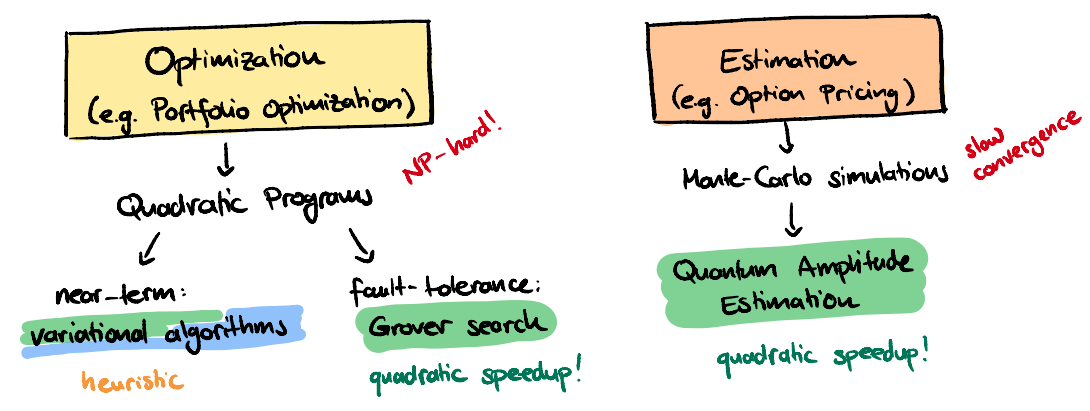

## Qiskit Finance 

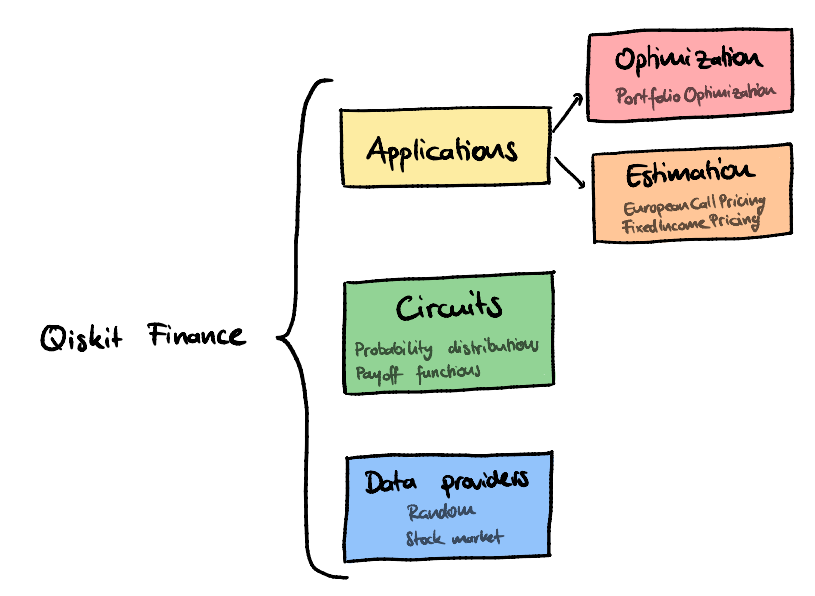

## Portfolio optimization

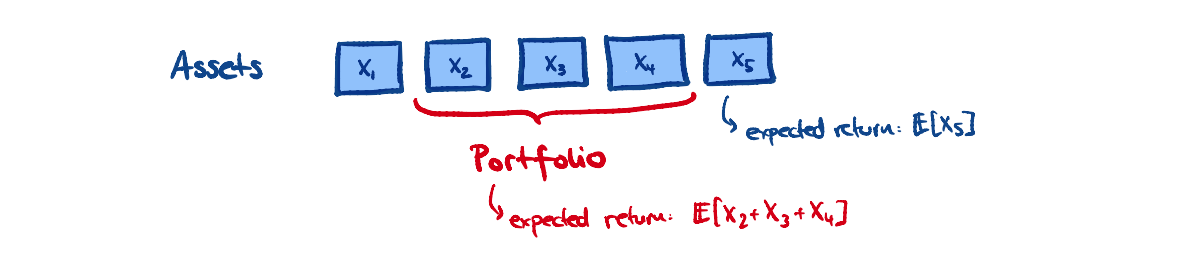

How can we optimize the portfolio to have the maximum return but at the same time has a small risk?

### Asset modelling

Collection of assets: Modelled with a multivariate probability distribution $\vec X = (X_1, ..., X_n)$.

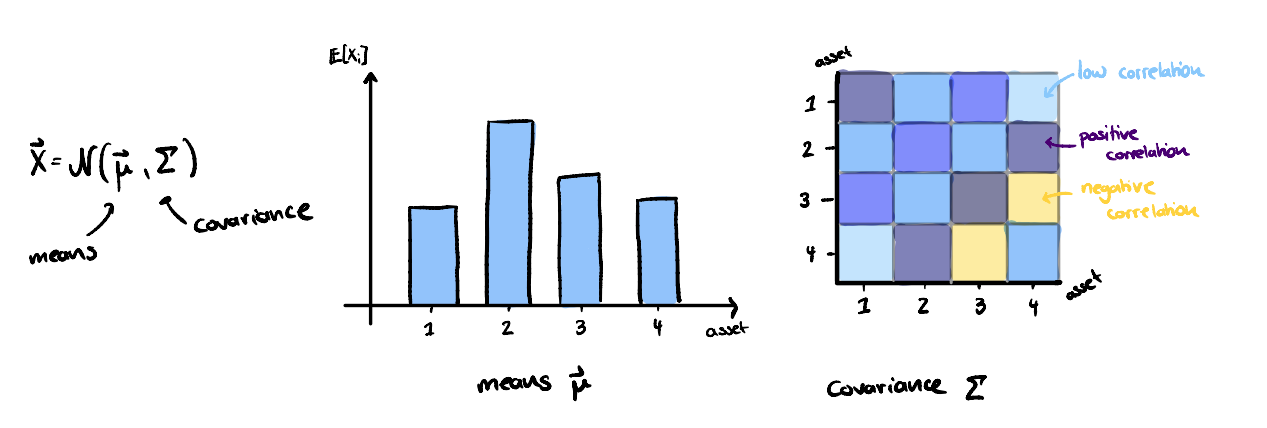

Optimal solution $\vec x^*$:

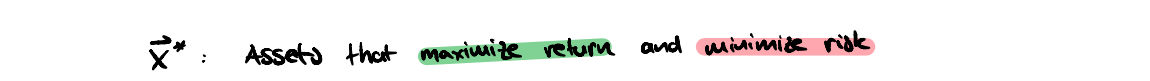

Or in a formula:

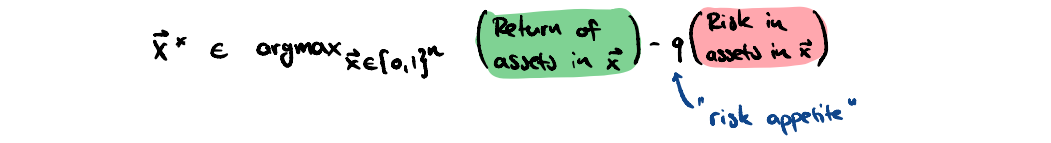

There are different ways to quantify risk -- first we'll define it as the _variance_ of the joint distribution:

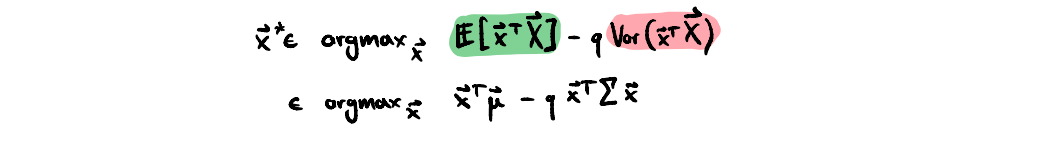

This is nothing but a quadratic program! These are well-studied and we can solve them with Qiskit.

### Quadratic program formulation

In [2]:
import numpy as np

mu = np.array([2.5, 4.2, 1])
sigma = np.array([[1, 0, -1],
                  [0, 1, 0.7],
                  [-1, 0.7, 1]])

budget = 2  # select 2 of the 3 assets
risk_factor = 0.7 # risk factor "q"

In Qiskit, there is the dedicated `PortfolioOptimization` application to construct the quadratic program for portfolio optimizations.

In [3]:
from qiskit_finance.applications.optimization import PortfolioOptimization

popt = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)

In [4]:
qp = popt.to_quadratic_program()
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 2.500000000000 x_0 - 4.200000000000 x_1 - x_2 + [ 1.400000000000 x_0^2
      - 2.800000000000 x_0*x_2 + 1.400000000000 x_1^2 + 1.960000000000 x_1*x_2
      + 1.400000000000 x_2^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1

Binaries
 x_0 x_1 x_2
End



Now we can solve the program either classically or with a quantum algorithm.

In [5]:
from qiskit_optimization.algorithms import CplexOptimizer  # classical optimization algorithm from IBM

cplex_optimizer = CplexOptimizer()
cplex_result = cplex_optimizer.solve(qp)

In [6]:
print(cplex_result)

optimal function value: -5.300000000000001
optimal value: [1. 1. 0.]
status: SUCCESS


Result: We should select asset 1 and 2!

**Note** This is a hard problem, classical algorithms only work for small instances!

### Recap on the Variational Quantum Eigensolver

Goal: Find ground state $|\Psi\rangle$ of the Hamiltonian $H$.

Idea: Choose model $|\phi(\theta)\rangle$ that can approximate $|\Psi\rangle$ well and minimize the energy

$$
    \theta^* = \text{argmin}_\theta E(\theta) = \text{argmin}_\theta \langle\phi(\theta)|H|\phi(\theta)\rangle 
$$

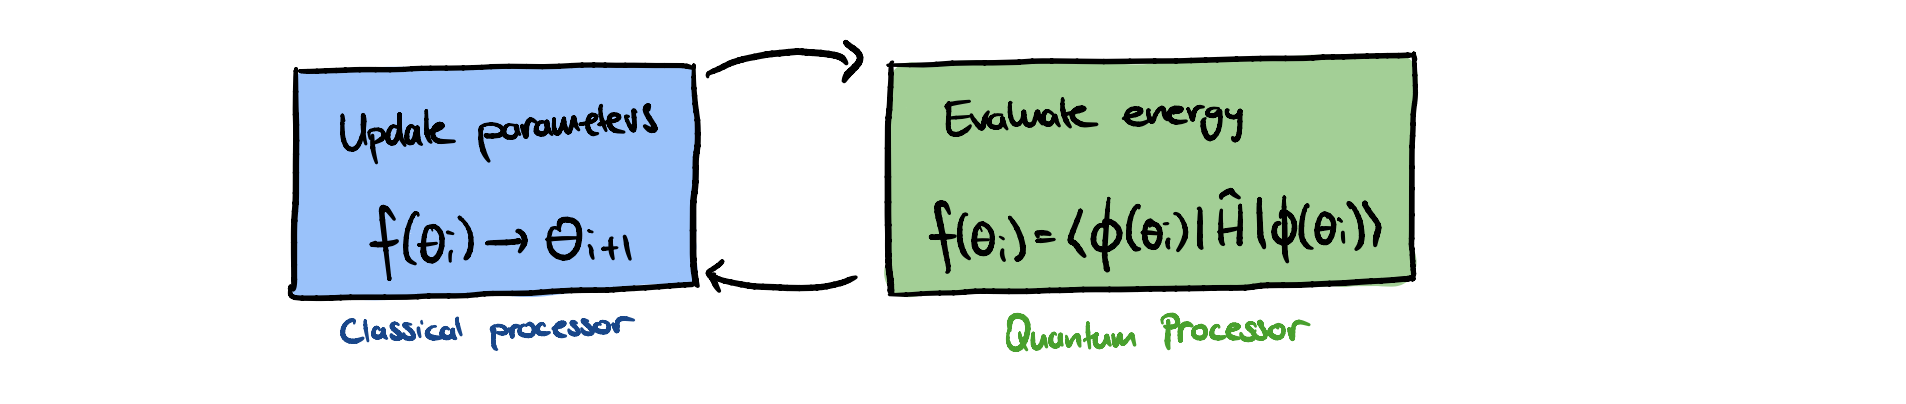

_A variational eigenvalue solver on a photonic quantum processor._ Peruzzo et al. (2014) [Nat Commun 5, 4213](https://www.nature.com/articles/ncomms5213)

With special $H$ we can solve quadratic unconstrained binary optimizations (QUBOs)!

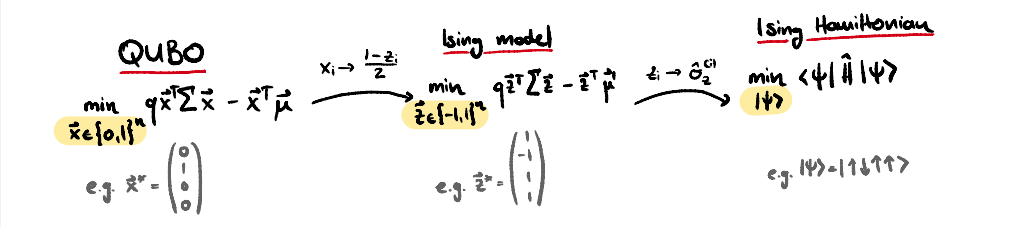

_Quantum optimization using variational algorithms on near-term quantum devices._ Moll et al. (2017) [arXiv:1710.01022](https://arxiv.org/abs/1710.01022)

### Solving the program with the VQE

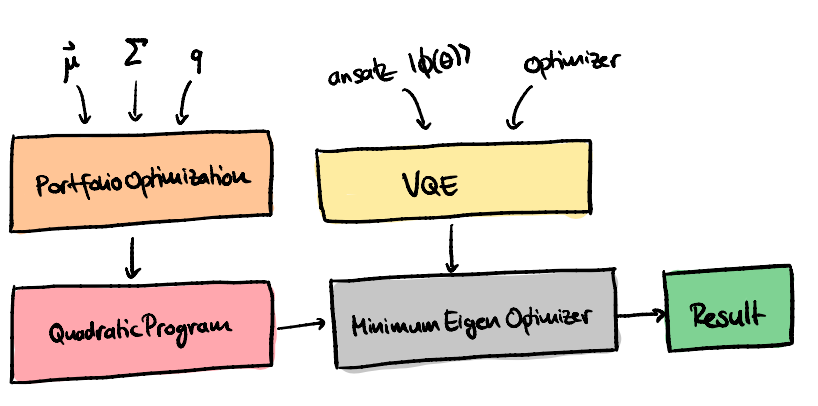

First, we'll select our simulator. This is Qiskit's shot-based local simulator.

In [7]:
from qiskit import Aer

sim = Aer.get_backend("qasm_simulator")

And the ansatz $\phi(\theta)$:

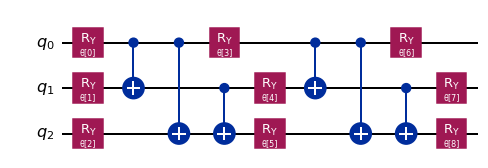

In [8]:
from qiskit.circuit.library import RealAmplitudes  # model |φ(θ)>

ansatz = RealAmplitudes(3, reps=2)
ansatz.decompose().draw('mpl', style='iqx')

In [25]:
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit_optimization.algorithms import MinimumEigenOptimizer

vqe = VQE(ansatz, optimizer=SLSQP(), quantum_instance=sim)
vqe_optimizer = MinimumEigenOptimizer(vqe) 

# the MinimumEigenOptimizer internally maps our quadratic program to an Ising Hamiltonian -- and back!
vqe_result = vqe_optimizer.solve(qp)

In [26]:
print(vqe_result)

optimal function value: -5.300000000000001
optimal value: [1. 1. 0.]
status: SUCCESS


We obtain the same result as before with the classical solver!

**Note** The performance depends strongly on the variational form and classical optimizer!

### Leveraging Qiskit Runtime

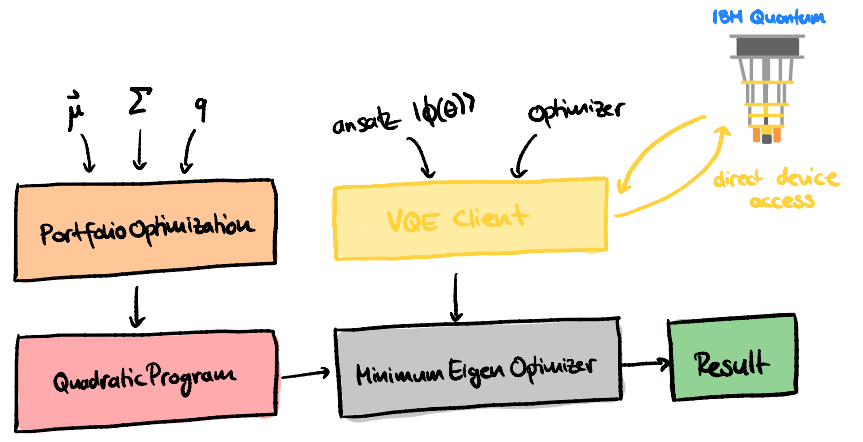

In [ ]:
from qiskit_optimization.runtime import VQEProgram  # soon to be called VQEClient

provider = # ... 
backend = # ...

vqe = VQEProgram(ansatz, optimizer=SLSQP(), provider=provider, backend=backend)
vqe_optimizer = MinimumEigenOptimizer(vqe) 

vqe_result = vqe_optimizer.solve(qp)

## Option pricing

Financial option: Right to buy or sell an asset for a certain price in a certain time window.

**Example** European call option

At a fixed maturity time $T$, you can buy an asset for a fixed strike price $K$. 

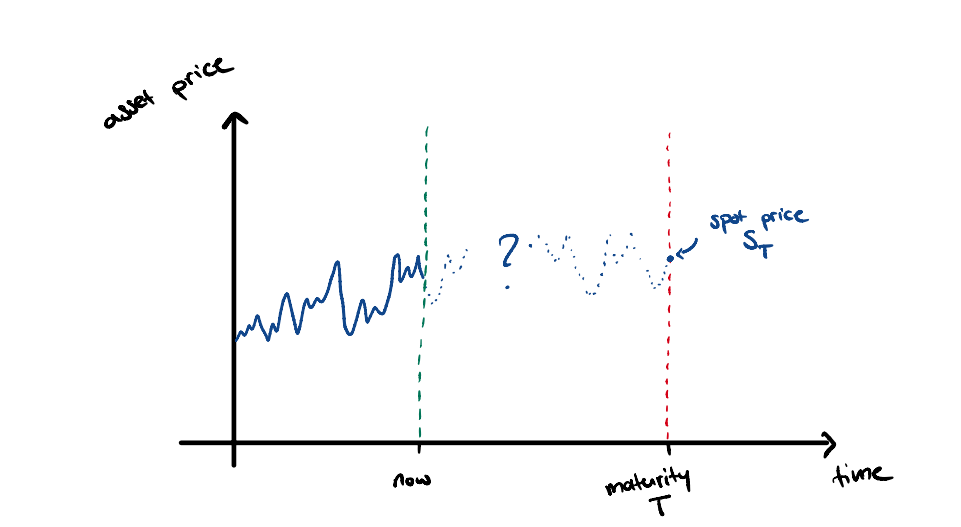

Question: Is it worth it? What's your expected payoff?

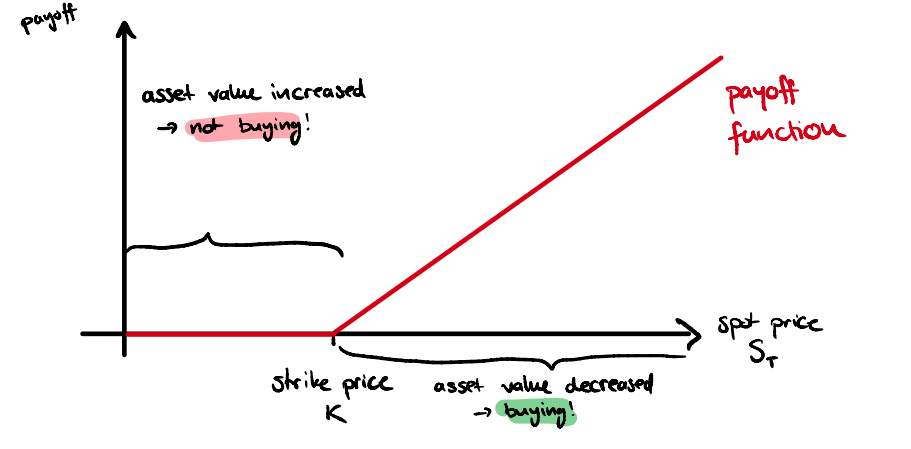

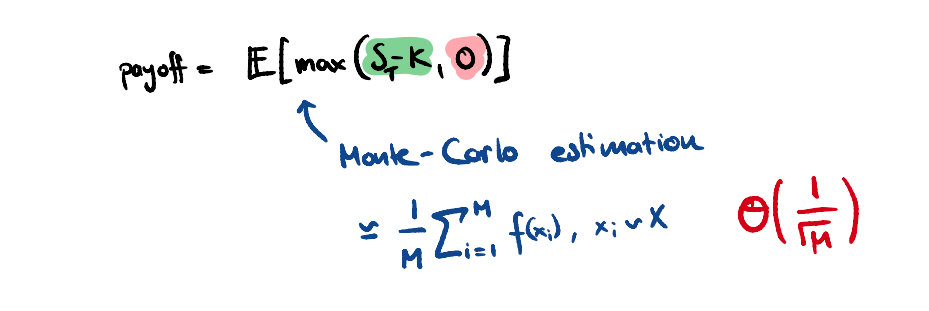

Can we do better with a quantum algorithm?

### Quantum amplitude estimation

Given an operator $\mathcal A$ with

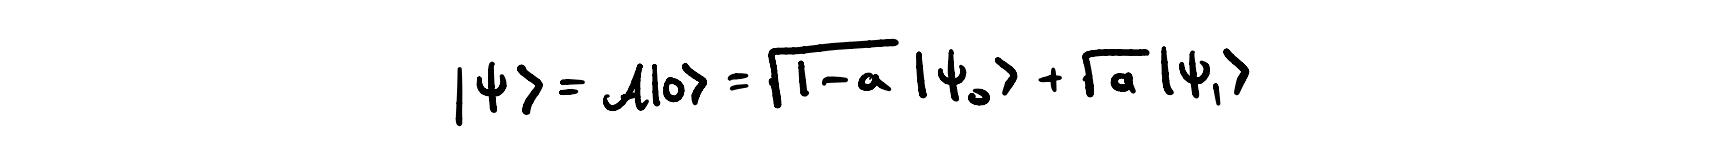

what's $a = |\langle\psi_1 | \psi_1\rangle|^2$?

Original algorithm from _Quantum Amplitude Amplification and Estimation._ Brassard et al. (2000) [arXiv:quant-ph/0005055](https://arxiv.org/abs/quant-ph/0005055):

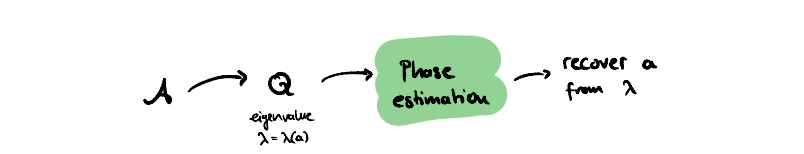

In [14]:
from qiskit.algorithms import AmplitudeEstimation

More information in _Quantum Amplitude Estimation_ tutorial in Qiskit Finance on [qiskit.org](https://qiskit.org/documentation/finance/tutorials/00_amplitude_estimation.html)

### Option pricing with amplitude estimation

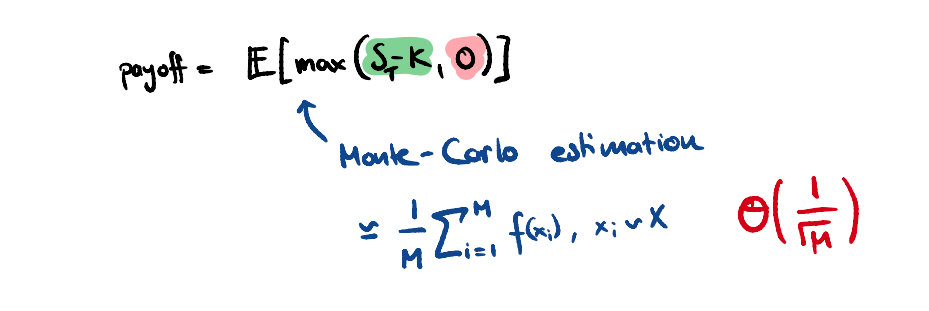

But Amplitude Estimation has a better convergence!

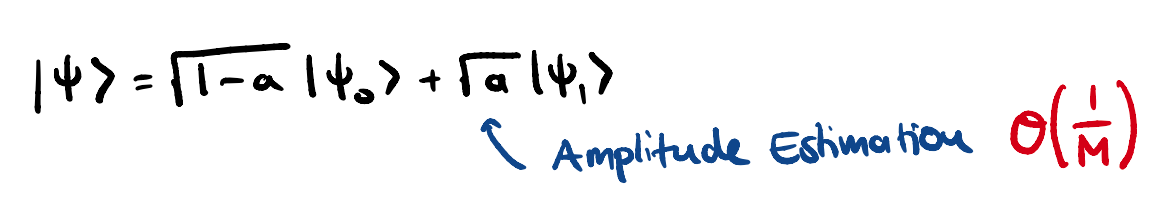

Can we formulate option pricing for amplitude estimation?

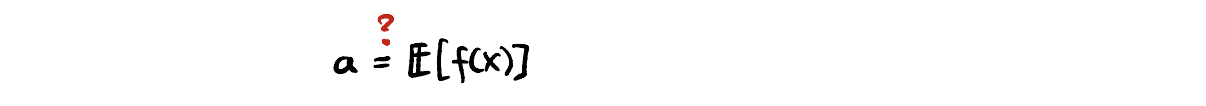

Yes, this is possible!

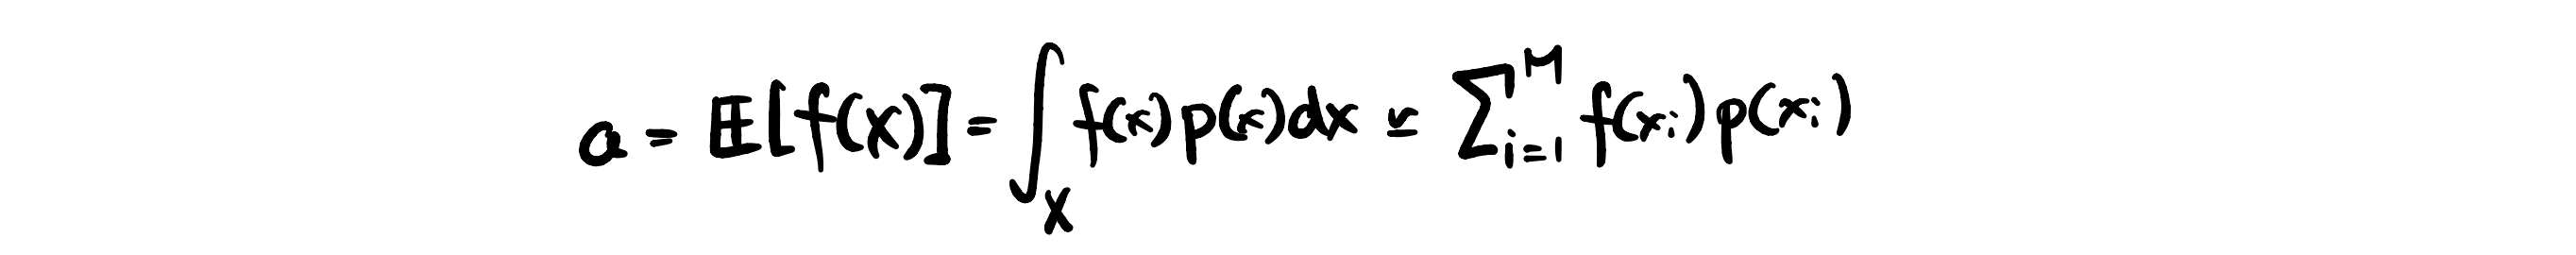

_Quantum Risk Analysis._ Woerner et al. (2019) [npj Quantum Inf 5, 15](https://www.nature.com/articles/s41534-019-0130-6)

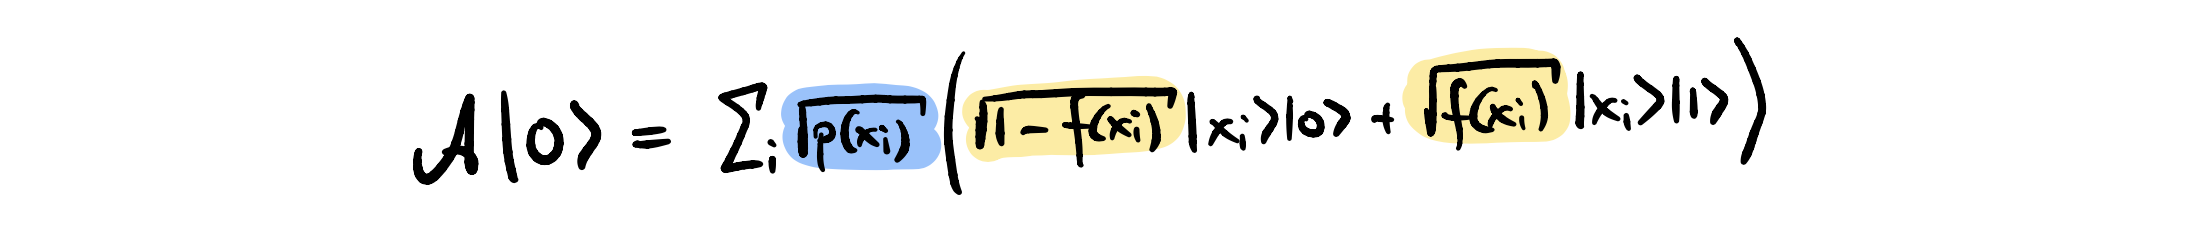

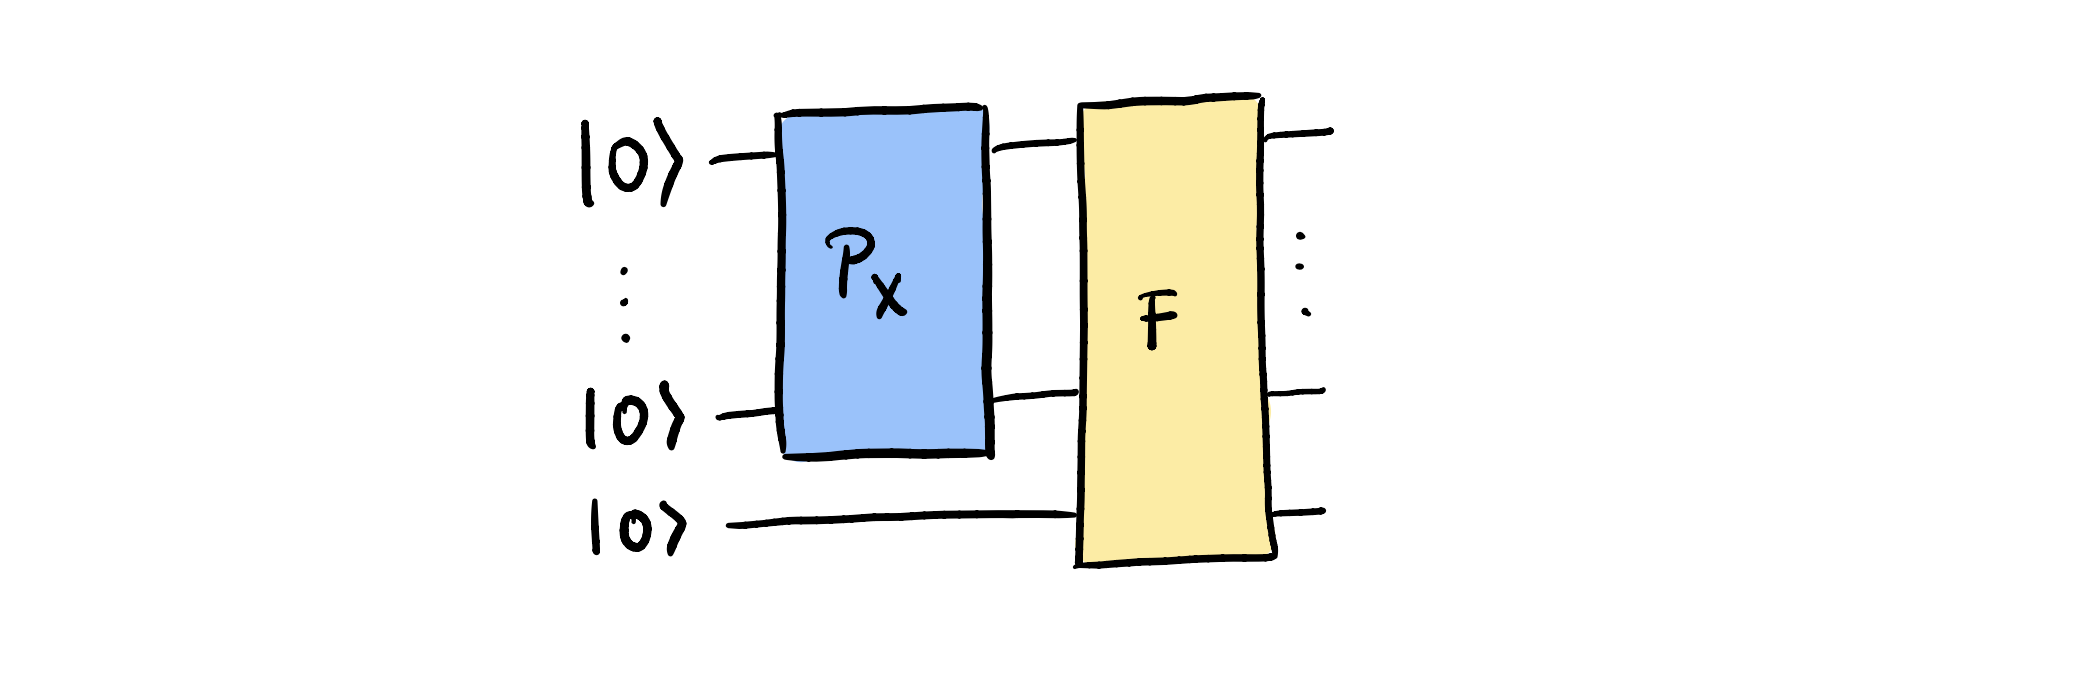

Qiskit's circuit library contains such circuits and tools to build them.

In [15]:
from qiskit_finance.circuit.library import EuropeanCallPricingObjective  # F
from qiskit_finance.circuit.library import LogNormalDistribution  # P_X

We'll use 3 qubits to represent the probability $\mathcal P_X$ distribution of the asset. This determines the accuracy of our integral and therefore our prediction.

In [16]:
num_uncertainty_qubits = 3

Using the Black-Scholes model we can analytically compute the probability distribution of the asset at time $T$.

_Quantum computational finance: Monte Carlo pricing of financial derivatives._ Rebentrost et al. (2018) [Phys. Rev. A 98, 022321](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.022321)

In [17]:
strike_price = 1.896   # agreed upon strike price
T = 40 / 365         # 40 days to maturity

S = 2.0              # initial spot price
vol = 0.4            # volatility of 40%
r = 0.05             # annual interest rate of 4%

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

Qiskit then knows how to load the distribution onto qubits.

In [18]:
distribution = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

More details and efficient loading: _Quantum Generative Adversarial Networks for Learning and Loading Random Distributions._ Zoufal et al. (2019)  Lucchi, Woerner [npj Quantum Inf 5, 103](https://www.nature.com/articles/s41534-019-0223-2).

Now we have everything to define our European Call option! 

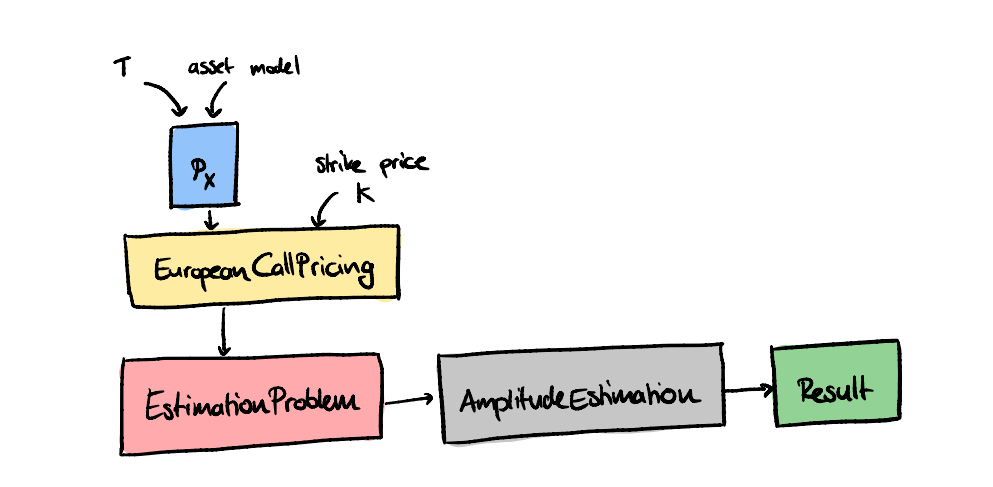

In [19]:
from qiskit_finance.applications import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(num_state_qubits=num_uncertainty_qubits,
                                            strike_price=strike_price,
                                            rescaling_factor=0.25,  # approximation constant for payoff function
                                            bounds=(low, high),
                                            uncertainty_model=distribution)

Qiskit's amplitude estimation algorithm take an `EstimationProblem` as input, let's convert it to one:

In [20]:
problem = european_call_pricing.to_estimation_problem()

We can have a look at the $\mathcal A$ operator:

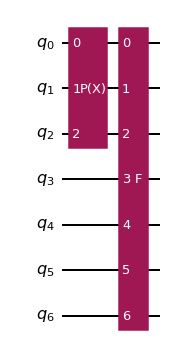

In [21]:
problem.state_preparation.draw('mpl', style='iqx')

We're using iterative amplitude estimation since it's one of the fastest algorithms.

In [22]:
from qiskit.algorithms import IterativeAmplitudeEstimation

epsilon = 0.01  # determines final accuracy
alpha = 0.05  # determines how certain we are of the result

ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=sim)

Now we can run the algorithm.

In [23]:
result = ae.estimate(problem)

In [24]:
print('Estimated value:    ', result.estimation_processed)
print('Confidence interval:', result.confidence_interval_processed)


Estimated value:     0.16462551841622297
Confidence interval: (0.15588799404401232, 0.1733630427884336)


More options with more constellations of assets exist, check for instance the [Qiskit finance tutorials](https://qiskit.org/documentation/finance/tutorials/)

## Summary

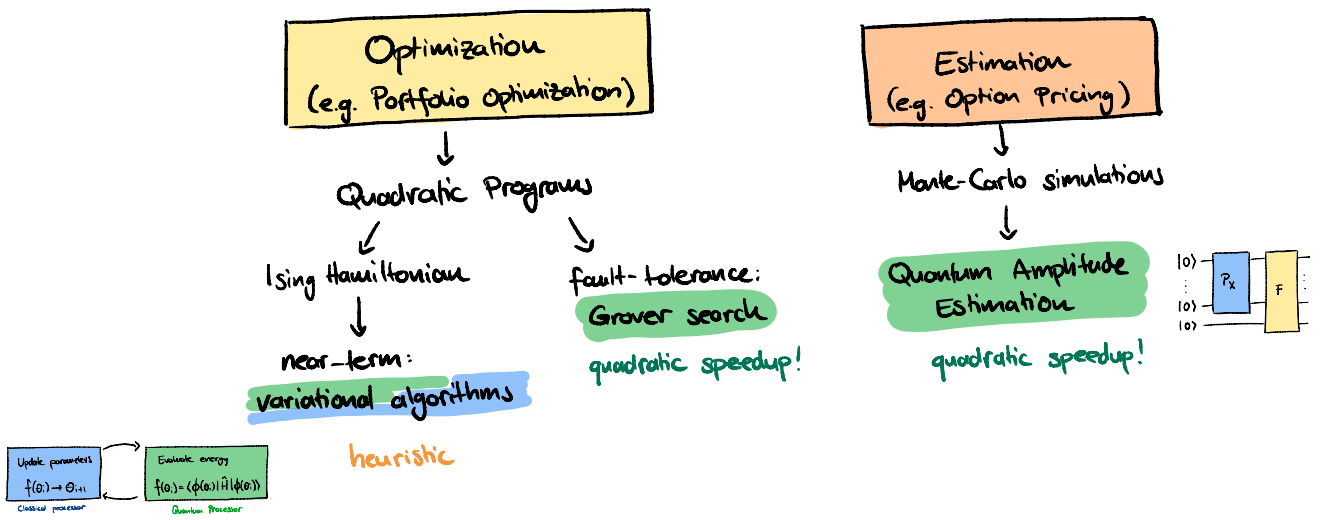

## References

Qiskit Finance tutorials: [qiskit.org/documentation/finance/tutorials/](https://qiskit.org/documentation/finance/tutorials/)

Portfolio Optimization:

_Quantum optimization using variational algorithms on near-term quantum devices._ Moll et al. (2017) [arXiv:1710.01022](https://arxiv.org/abs/1710.01022)

Option pricing:

_Quantum computational finance: Monte Carlo pricing of financial derivatives._ Rebentrost et al. (2018) [Phys. Rev. A 98, 022321](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.022321)<br>
_Credit Risk Analysis using Quantum Computers._ Egger et al. (2020) [IEEE Transactions on Computers, vol. , no. 01, pp. 1-1, 5555](https://www.computer.org/csdl/journal/tc/5555/01/09259208/1oIWv6R1eTK) <br>
_Quantum Risk Analysis._ Woerner et al. (2019) [npj Quantum Inf 5, 15](https://www.nature.com/articles/s41534-019-0130-6)<br>
_Option Pricing using Quantum Computers._ Stamatopoulos et al. (2020) [Quantum 4, 291](https://quantum-journal.org/papers/q-2020-07-06-291/#) <br>
_Quantum Generative Adversarial Networks for Learning and Loading Random Distributions._ Zoufal et al. (2019)  Lucchi, Woerner [npj Quantum Inf 5, 103](https://www.nature.com/articles/s41534-019-0223-2)<br>

## Backup slides

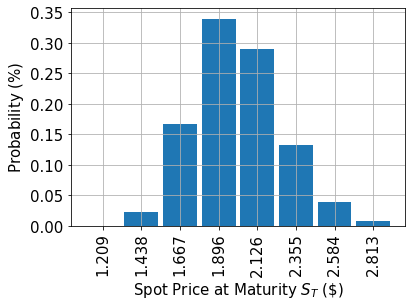

In [68]:
import matplotlib.pyplot as plt 
x = distribution.values
y = distribution.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

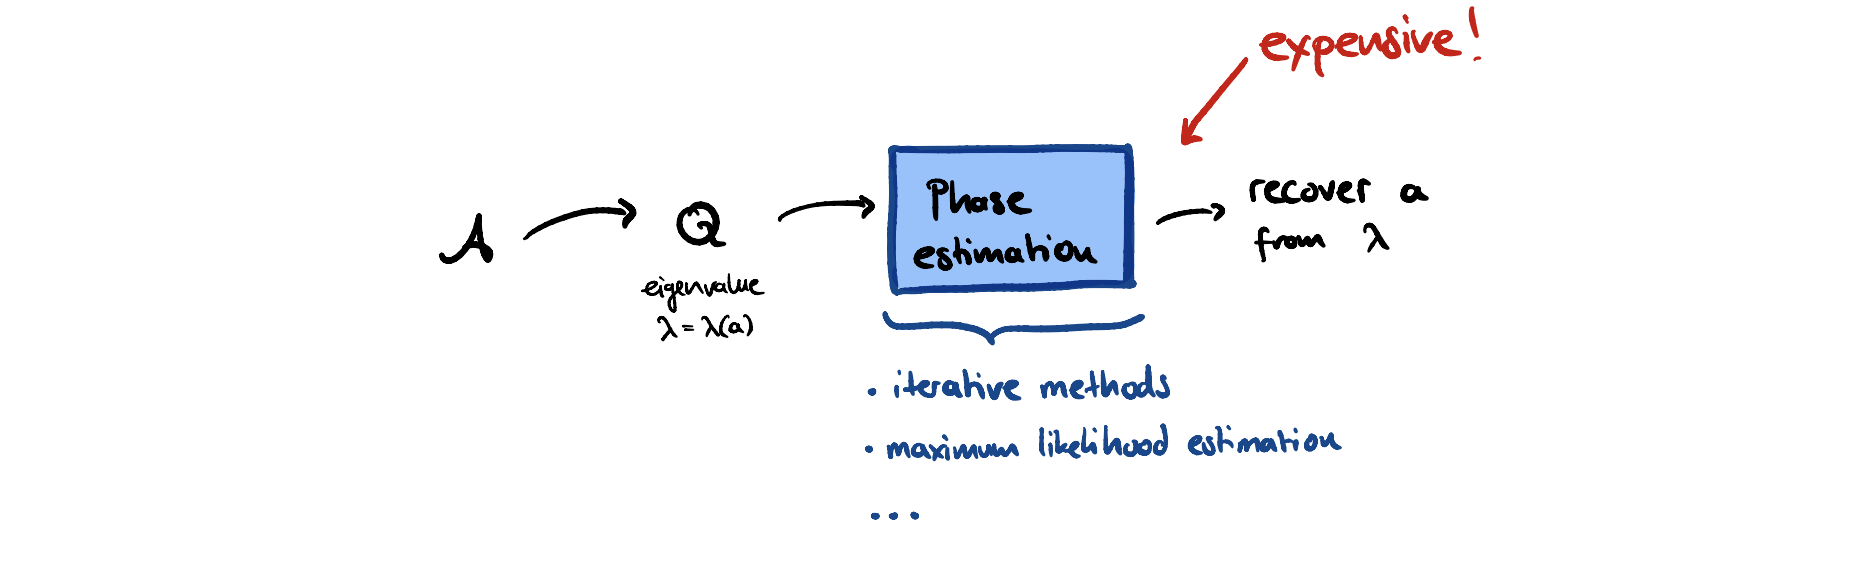

In [12]:
from qiskit.algorithms import (
    IterativeAmplitudeEstimation,
    MaximumLikelihoodAmplitudeEstimation,
    FasterAmplitudeEstimation
)

More information in _Quantum Amplitude Estimation_ tutorial in Qiskit Finance on [qiskit.org](https://qiskit.org/documentation/finance/tutorials/00_amplitude_estimation.html)

References:

_Quantum Amplitude Amplification and Estimation._ Brassard et al. (2000) [arXiv:quant-ph/0005055](https://arxiv.org/abs/quant-ph/0005055) <br>
_Amplitude Estimation without Phase Estimation._ Suzuki et al. (2019) [Quantum Inf Process 19, 75](https://link.springer.com/article/10.1007/s11128-019-2565-2)<br>
_Iterative Quantum Amplitude Estimation._ Grinko et al. (2019) [npj Quantum Inf 7, 52](https://www.nature.com/articles/s41534-021-00379-1)<br>
_Quantum Approximate Counting, Simplified._ Aaronson et al. (2019) [arXiv:1908.10846](https://arxiv.org/abs/1908.10846)<br>
_Faster Amplitude Estimation._ Nakaji (2020) [arXiv:2003.02417](https://arxiv.org/abs/2003.02417)